# **Descriptive Analysis of Youtube Channel data**


# **1. Objective**

Objective of this project is to Analyse my Favourite Data Analytics Youtube Channel ***StatQuest with Josh Starmer***. I have been watching this channel for a long time now and I'm interested to know more about this channel's journey throughout the year. 

This project is done in 2 steps
1. Data collection using Youtube Data V3 API
2. Data Analysis mainly using SQL

**Reference**
> https://developers.google.com/youtube/v3/docs

# **2. Data Collection**

In [ ]:
from googleapiclient.discovery import build

import pandas as pd
import numpy as np
import isodate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

## **2.1 Setting up Youtube data v3 api**

In [ ]:
secret_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
youtube = build('youtube', 'v3', developerKey=secret_key)

## **2.2  Reading Channel Details for Josh Starmer Channel**

In [ ]:
#Channel id for Josh Starmer Channel
channel_id = 'UCtYLUTtgS3k1Fg4y5tAhLbw' 
request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id= channel_id
)
response = request.execute()
for item in response['items']:
    channel = {
            'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
    }

In [ ]:
channel_data = pd.DataFrame(channel,index=[0])
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,StatQuest with Josh Starmer,836000,39844495,226,UUtYLUTtgS3k1Fg4y5tAhLbw


In [ ]:
#converting to numberic type
channel_data.subscribers = pd.to_numeric(channel_data.subscribers)
channel_data.views = pd.to_numeric(channel_data.views)
channel_data.totalVideos = pd.to_numeric(channel_data.totalVideos)

## **2.3. Getting Playlist videos using playlistId**

In [ ]:
playlist_id = 'UUtYLUTtgS3k1Fg4y5tAhLbw'
video_list = []

request = youtube.playlistItems().list(
    part="snippet,contentDetails",
    playlistId=playlist_id,
    maxResults = 50
)
response = request.execute()
for item in response['items']:
    video_list.append(item['contentDetails']['videoId'])
#since there are more than 50 videoes, use nextPageToken to access next pages until nextPageToken is none
next_page_token = response.get('nextPageToken')
while next_page_token:
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50,
                pageToken = next_page_token)
    response = request.execute()
    for item in response['items']:
        video_list.append(item['contentDetails']['videoId'])
    #get next page token for subsequent page
    next_page_token = response.get('nextPageToken')

## **2.4. Get video details for all the videos in the playlist**

In [ ]:
video_details_all = []

for i in range(0, len(video_list), 50):
    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=','.join(video_list[i:i+50])
    )
    response = request.execute() 
    
    for video in response['items']:
        data = {'snippet': ['channelTitle', 'title', 'description', 'publishedAt'],
                'statistics': ['viewCount', 'likeCount' ,'commentCount'],
                'contentDetails': ['duration']
               }
        video_details = {}
        video_details['video_id'] = video['id']

        for k in data.keys():
            for v in data[k]:
                 video_details[v] = video[k][v]
        video_details_all.append(video_details)   

In [ ]:
videos = pd.DataFrame(video_details_all)

In [ ]:
videos.columns

Index(['video_id', 'channelTitle', 'title', 'description', 'publishedAt',
       'viewCount', 'likeCount', 'commentCount', 'duration'],
      dtype='object')

In [ ]:
#converting to numberic type
videos.viewCount = pd.to_numeric(videos.viewCount)
videos.likeCount = pd.to_numeric(videos.likeCount)
videos.commentCount = pd.to_numeric(videos.commentCount)

In [ ]:
# Creating day of the week columnn from date
videos['publishedAt']  = pd.to_datetime(videos['publishedAt'] )
videos['publishedAt']= videos['publishedAt'].dt.tz_localize(None)
videos['publishDay'] = videos['publishedAt'].apply(lambda x: x.strftime("%A")) 
videos.set_index(pd.to_datetime(videos['publishedAt']), inplace=True) 
videos.drop(columns = 'publishedAt',inplace = True)

In [ ]:
# creating duration in seconds
videos['duration'] = videos['duration'].apply(lambda x: isodate.parse_duration(x))
videos['duration'] = videos['duration'].astype('timedelta64[s]')

# **3. Analysis using SQL**

## **3.1 Creating Sqlite Db Connection and create table**

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
import sqlite3
conn = sqlite3.connect("youtube.db")
channel_data.to_sql("channel_data", conn,index = False)
videos.to_sql("video_data", conn)

In [ ]:
tables = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type='table'",conn)
tables = tables["Table_Name"].values.tolist()

In [ ]:
for table in tables:
    query = "PRAGMA TABLE_INFO({})".format(table)
    schema = pd.read_sql_query(query,conn)
    print("Schema of",table)
    display(schema)
    print("-"*100)
    print("\n")

Schema of channel_data


,cid,name,type,notnull,dflt_value,pk
0,0,channelName,TEXT,0,None,0
1,1,subscribers,INTEGER,0,None,0
2,2,views,INTEGER,0,None,0
3,3,totalVideos,INTEGER,0,None,0
4,4,playlistId,TEXT,0,None,0


----------------------------------------------------------------------------------------------------


Schema of video_data


,cid,name,type,notnull,dflt_value,pk
0,0,publishedAt,TIMESTAMP,0,None,0
1,1,video_id,TEXT,0,None,0
2,2,channelTitle,TEXT,0,None,0
3,3,title,TEXT,0,None,0
4,4,description,TEXT,0,None,0
5,5,viewCount,INTEGER,0,None,0
6,6,likeCount,INTEGER,0,None,0
7,7,commentCount,INTEGER,0,None,0
8,8,duration,REAL,0,None,0
9,9,publishDay,TEXT,0,None,0


----------------------------------------------------------------------------------------------------




## **3.2 Channel Level Stats**

In [ ]:
query = """select 
              channelTitle,subscribers,
              count(video_id) videos,
              sum(viewCount) views, 
              sum(likeCount) likes, 
              sum(commentCount) comments
              from channel_data c
              inner join video_data v
              on channelTitle = channelName
              group by 1,2"""
q1 = pd.read_sql_query(query,conn)
q1

,channelTitle,subscribers,videos,views,likes,comments
0,StatQuest with Josh Starmer,836000,227,39871753,913692,69029


## **3.2 Top 10 videos by views (using limit)**

In [ ]:
query = """select 
              title Title ,
              viewCount [Total Views]
              from  video_data
              order by  2 desc
              limit 10"""
result = pd.read_sql_query(query,conn)
result

,Title,Total Views
0,"StatQuest: Principal Component Analysis (PCA), Step-by-Step",2062197
1,StatQuest: Logistic Regression,1541892
2,StatQuest: K-means clustering,1069884
3,Probability is not Likelihood. Find out why!!!,1033805
4,"Maximum Likelihood, clearly explained!!!",1023449
5,"ROC and AUC, Clearly Explained!",1010300
6,Support Vector Machines Part 1 (of 3): Main Ideas!!!,926904
7,Principal Component Analysis (PCA) clearly explained (2015),910466
8,Machine Learning Fundamentals: Bias and Variance,906232
9,StatQuest: PCA main ideas in only 5 minutes!!!,881890


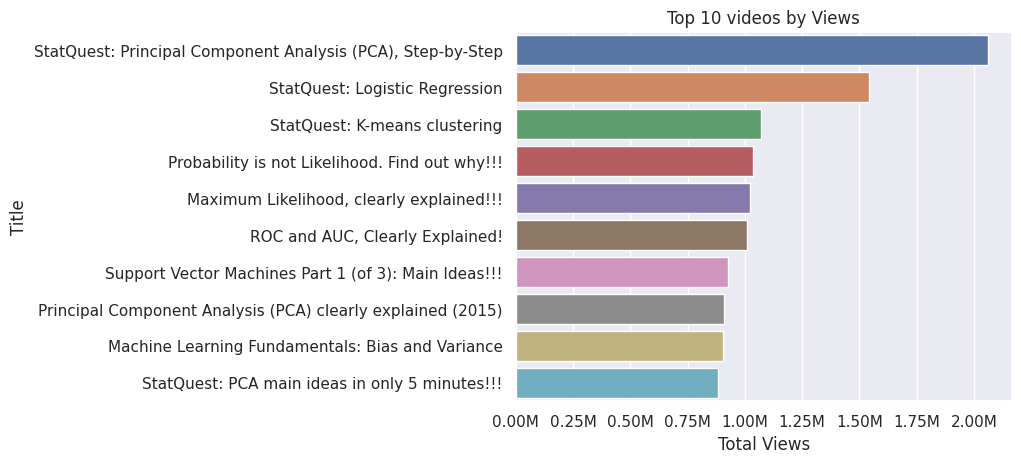

In [ ]:
ax = sns.barplot(x = result['Total Views'],y =result['Title'],  orient = 'h')
ax.set(title='Top 10 videos by Views')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'M'))


* StatQuest: Principal Component Analysis (PCA), Step-by-Step is the video with most views - with 2,052,983. This is one of my favourite videos from the channel too!
* Top 10 Videos are a mix of Machine learning and Stat Concepts

## **3.3 Bottom 10 videos by Views**

In [ ]:
query = """ select 
              title Title,
              viewCount [Total Views]
              from  video_data
              order by  2 
              limit 10           
     """
result = pd.read_sql_query(query,conn)
result

,Title,Total Views
0,StatQuest with Josh Starmer Live Stream,0
1,Roses,360
2,Another Day,407
3,Nasty Weather,675
4,The Coldest Day of the Year,694
5,The Sum of Regrets,704
6,A New Song,704
7,Brothers,721
8,Rachel's Song (the ballad of Hazel Motes),756
9,Mr Hattie,760


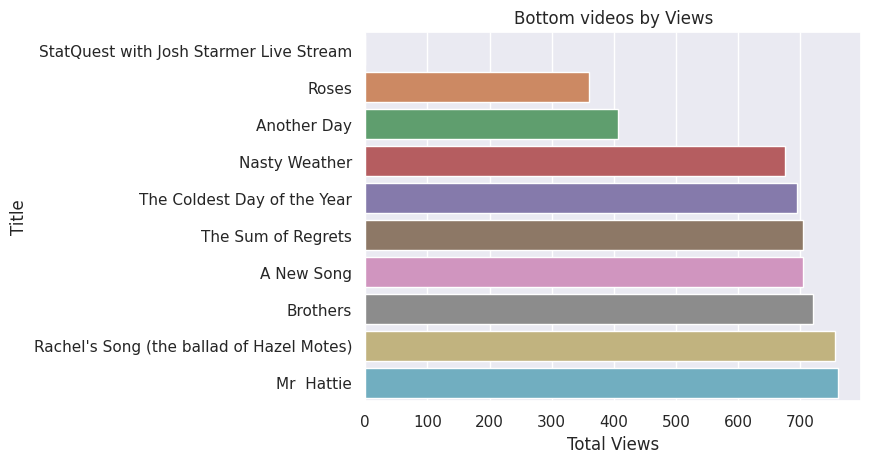

In [ ]:
ax = sns.barplot(x = result['Total Views'],y =result['Title'],  orient = 'h').set(title='Bottom videos by Views')

* None of the bottom 10 videos are Tutorials.
* StatQuest with Josh Starmer Live Stream seems to be a glitch with zero views

## **3.4. Top and Bottom 5(without using limit )**

In [ ]:
query = """
          select 
              title Title,
              "Bottom 5" Category,
              viewCount [Total Views]
              from  video_data v1
              where 5 > ( 
                select count(distinct viewCount) from video_data v2 where v1.viewCount > v2.viewCount
              )
          union 
          select 
              title Title,
              "Top 5" Category,
              viewCount [Total Views]
              from  video_data v1
              where 5 > ( 
                select count(distinct viewCount) from video_data v2 where v1.viewCount < v2.viewCount
              )
              order by 3 desc
           

        """
result = pd.read_sql_query(query,conn)

In [ ]:
#https://towardsdatascience.com/a-quick-and-easy-guide-to-conditional-formatting-in-pandas-8783035071ee
def highlight_rows(row):
    value = row.loc['Category']
    if value == 'Bottom 5':
        color = '#FFB3BA' # Red
    else :
        color = '#BAFFC9' # Green
    return ['background-color: {}'.format(color) for r in row]

result.style.apply(highlight_rows, axis=1)

,Title,Category,Total Views
0,"StatQuest: Principal Component Analysis (PCA), Step-by-Step",Top 5,2062197
1,StatQuest: Logistic Regression,Top 5,1541892
2,StatQuest: K-means clustering,Top 5,1069884
3,Probability is not Likelihood. Find out why!!!,Top 5,1033805
4,"Maximum Likelihood, clearly explained!!!",Top 5,1023449
5,The Coldest Day of the Year,Bottom 5,694
6,Nasty Weather,Bottom 5,675
7,Another Day,Bottom 5,407
8,Roses,Bottom 5,360
9,StatQuest with Josh Starmer Live Stream,Bottom 5,0


## **3.5. Top 10 longest videos(using windows function)**

In [ ]:
query = """with longest as (
           select 
              title Title ,
              round(cast(duration as float)/60.0,2) [Duration in Minutes],
              dense_rank() over (order by duration desc ) rnk
              from  video_data)
           select Title,[Duration in Minutes]  from longest where rnk <= 10"""
result = pd.read_sql_query(query,conn)
result

,Title,Duration in Minutes
0,The Elements of StatQuest (Webinar),73.65
1,Classification Trees in Python from Start to Finish,66.40
2,Live Stream - Target Encoding/AMA/Silly Songs!!!,57.42
3,XGBoost in Python from Start to Finish,56.72
4,Live Stream - More details about Target Encoding/AMA/Silly Songs,51.30
5,Live Stream - Mutual Information/AMA/Ukulele Songs!!!,47.32
6,Support Vector Machines in Python from Start to Finish.,44.82
7,The Cosine Similarity for NLP and CatBoost,43.67
8,Live 2020-03-16!!! Naive Bayes,38.52
9,Live 2020-02-17!!! Imbalanced Data and Post-Hoc Tests,37.13


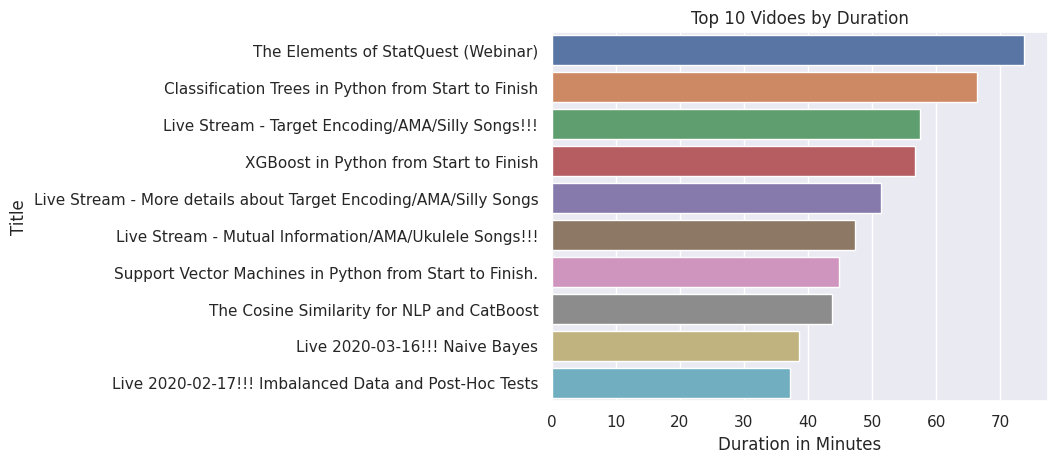

In [ ]:
ax = sns.barplot(x = result['Duration in Minutes'],y =result['Title'],  orient = 'h').set(title='Top 10 Vidoes by Duration')

* There are 5 Live videos in the top 10 videos, there are fewer Live videos in the channel. So it's possible that average duration of Live videos are more than non-live videos. We will verify that next

## **3.6. Mean duration of all videos**

In [ ]:
query = """select 
              ROUND(avg(cast(duration as float)/60.0),1) mean_duration_mins
              from  video_data"""
result = pd.read_sql_query(query,conn)
result

,mean_duration_mins
0,12.9


## **3.7. Mean Duration of Live vs Non-Live Videos**

In [ ]:
query = """with cte_live as 
              (select 
                  title,
                  case when lower(title) like 'live%' then "Live" else "Non-Live" end as live_flag,
                  duration 
                  from  video_data
              )   
            select live_flag,
                   round(avg(cast(duration as float)/60.0),1) mean_duration_mins
                   from   cte_live    
                   group by live_flag
        """
result = pd.read_sql_query(query,conn)
result

,live_flag,mean_duration_mins
0,Live,36.0
1,Non-Live,11.3


* As expected duration of Live videos are significantly more than non-live videos

## **3.8. Binning Duration and counting Live vs Non Live videos in bins**

In [ ]:
query = """with cte_live as 
              (select 
                  title,
                  case when lower(title) like 'live%' then "Live" else "Non-Live" end as live_flag,
                  case when (cast(duration as float)/60.0) > 60  then "Abv 60 mins"
                       when (cast(duration as float)/60.0) >= 45 then "45-60 mins"
                       when (cast(duration as float)/60.0) >= 30 then "30-44 mins"
                       when (cast(duration as float)/60.0) >= 15 then "15-29 mins"
                       else "0-14 mins" end as durations_mins_bins
                  from  video_data
              )   
            select durations_mins_bins,
                   sum(case when live_flag = "Live" then 1 else 0 end) Live_count,
                   sum(case when live_flag = "Non-Live" then 1 else 0 end) Non_Live_count 
                   from   cte_live   
                   group by  durations_mins_bins
                   order by  durations_mins_bins
        """
result = pd.read_sql_query(query,conn)
result

,durations_mins_bins,Live_count,Non_Live_count
0,0-14 mins,0,149
1,15-29 mins,3,57
2,30-44 mins,9,3
3,45-60 mins,3,1
4,Abv 60 mins,0,2


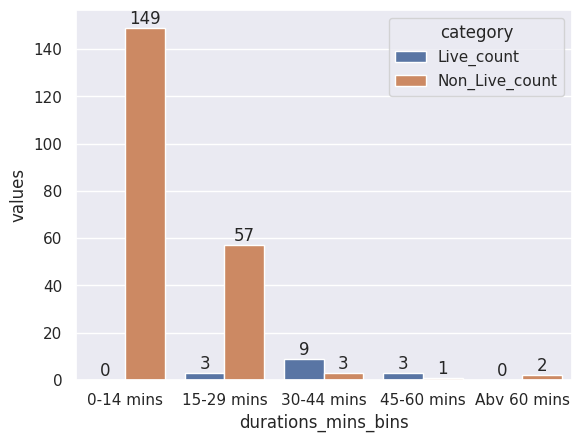

In [ ]:
df = result.set_index('durations_mins_bins').unstack().to_frame(name='values').reset_index()
df.rename(columns={'level_0':'category'}, inplace=True)
ax = sns.barplot(x='durations_mins_bins', y='values', hue='category', data=df)
for i in ax.containers:
    ax.bar_label(i,)

* Most Non-Live videos are falling in the bin of 0-14 mins, that is many non-live videos are relatively short
* Most of Live videos are falling in 30-44 mins bin

## **3.9. Videos with highest view in each of the duration bin**

---



In [ ]:
query = """with cte_live as 
              (select 
                  title Title,
                  viewCount Views,
                  case when lower(title) like 'live%' then "Live" else "Non-Live" end as live_flag,
                  case when (cast(duration as float)/60.0) > 60  then "Above 60 mins"
                       when (cast(duration as float)/60.0) >= 45 then "45 - 60 mins"
                       when (cast(duration as float)/60.0) >= 30 then "30 - 44 mins"
                       when (cast(duration as float)/60.0) >= 15 then "15 - 29 mins"
                       else "0-14 mins" end as [Duration]
                  from  video_data
              ),
              ranking as ( 
              select 
                  *,
                  dense_rank() over(partition by Duration order by Views desc) as rnk  
                  from cte_live
              )
              select 
                  Title,
                  Duration,
                  Views    
                  from ranking 
                  where rnk = 1
        """
result = pd.read_sql_query(query,conn)

In [ ]:
def highlight_rows(row):
    value = row.loc['Views']
    if value == mx :
        color = '#BAFFC9' # Green
    else  :
        color = '#0' # Green
    return ['background-color: {}'.format(color) for r in row]
mx= result.Views.max()
result.style.apply(highlight_rows, axis=1)

,Title,Duration,Views
0,StatQuest: Logistic Regression,0-14 mins,1541892
1,"StatQuest: Principal Component Analysis (PCA), Step-by-Step",15 - 29 mins,2062197
2,Gradient Boost Part 4 (of 4): Classification Details,30 - 44 mins,90592
3,XGBoost in Python from Start to Finish,45 - 60 mins,145154
4,Classification Trees in Python from Start to Finish,Above 60 mins,138025


* Videos with highest view in each bin is given above, StatQuest: Principal Component Analysis (PCA), Step-by-Step in bin 15-19 mins topped all of the videos

## **3.10. Videos with lowest views in each of the duration bin**


In [ ]:
query = """with cte_live as 
              (select 
                  title,
                  viewCount,
                  case when lower(title) like 'live%' then "Live" else "Non-Live" end as live_flag,
                  case when (cast(duration as float)/60.0) > 60  then "Above 60 mins"
                       when (cast(duration as float)/60.0) >= 45 then "45 - 60 mins"
                       when (cast(duration as float)/60.0) >= 30 then "30 - 44 mins"
                       when (cast(duration as float)/60.0) >= 15 then "15 - 29 mins"
                       else "0-14 mins" end as Duration
                  from  video_data
              )
              select 
                  title Title,
                  Duration,
                  viewCount Views
                  from cte_live c1
                  where   1 > 
                  (select 
                      count(distinct viewCount) 
                      from cte_live c2
                      where c2.viewCount < c1.viewCount 
                            and c1.Duration = c2.Duration 
                            
                  )
                  order by Duration
        """
result = pd.read_sql_query(query,conn)

In [ ]:
def highlight_rows(row):
    value = row.loc['Views']
    if value == mn :
        color = '#FFB3BA' # Green
    else  :
        color = '#0' # Green
    return ['background-color: {}'.format(color) for r in row]
mn= result.Views.min()
result.style.apply(highlight_rows, axis=1)

,Title,Duration,Views
0,StatQuest with Josh Starmer Live Stream,0-14 mins,0
1,"Linear Regression, Clearly Explained!!!",15 - 29 mins,5198
2,Live 2020-03-02!!! Virus Models and p-hacking,30 - 44 mins,5718
3,Live Stream - More details about Target Encoding/AMA/Silly Songs,45 - 60 mins,5654
4,The Elements of StatQuest (Webinar),Above 60 mins,8268


* Videos with lowest view in each bin is given above, StatQuest with Josh Starmer Live Stream in bin 0-14 mins has the least views ie 0. 0 views seems like a video with glitch. Let's verify

In [ ]:
query = """select 
                *
                from video_data
                where title = 'StatQuest with Josh Starmer Live Stream'
        """
pd.read_sql_query(query,conn)

,publishedAt,video_id,channelTitle,title,description,viewCount,likeCount,commentCount,duration,publishDay
0,2022-09-19 11:56:32,BgxBEKhaqyQ,StatQuest with Josh Starmer,StatQuest with Josh Starmer Live Stream,"For a complete index of all the StatQuest videos, check out...\nhttps://app.learney.me/maps/StatQuest\n...or...\nhttps://statquest.org/video-index/\n\nIf you'd like to support StatQuest, please consider...\nPatreon: https://www.patreon.com/statquest\n...or...\nYouTube Membership: https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw/join\n\n...a cool StatQuest t-shirt or sweatshirt: \nhttps://shop.spreadshirt.com/statquest-with-josh-starmer/\n\n...buying one or two of my songs (or go large and get a whole album!)\nhttps://joshuastarmer.bandcamp.com/\n\n...or just donating to StatQuest!\nhttps://www.paypal.me/statquest\n\nLastly, if you want to keep up with me as I research and create new StatQuests, follow me on twitter:\nhttps://twitter.com/joshuastarmer\n\n#StatQuest",0,0,0,0.0,Monday


0 Views and 0 Duration means the video had some glitch

## **3.11. Yearly stats on channel performance**





In [ ]:
query = """
            select 
                   strftime('%Y',publishedAt) year,
                   count(title) videos,
                   sum(viewCount) views,
                   sum(commentCount) comments,
                   sum(likeCount) likes,
                   sum(duration/60)/count(title)duration_per_video_mins,
                   sum(viewCount)/count(title) views_per_video,
                   sum(commentCount)/count(title) comments_per_video,
                   sum(likeCount)/count(title) likes_per_video,
                   cast(sum(likeCount) as float)/sum(viewCount)* 1000.0 like_view_ratio,
                   cast(sum(commentCount) as float)/sum(viewCount)* 1000.0 comment_view_ratio
                   from   video_data  
                   group by 1
                   order by 1 
        """
result = pd.read_sql_query(query,conn)

In [ ]:
#https://python.plainenglish.io/excel-style-conditional-formatting-in-pandas-1238277ed70a
def color_scales(styler):
    styler.set_caption("Yearly Stats")
    styler.background_gradient(axis=0, cmap="RdYlGn")
    styler.format(precision=2)
    return styler
result.style.pipe(color_scales)

,year,videos,views,comments,likes,duration_per_video_mins,views_per_video,comments_per_video,likes_per_video,like_view_ratio,comment_view_ratio
0,2014,2,22642,83,266,0.62,11321,41,133,11.75,3.67
1,2015,10,1521558,1856,23542,7.11,152155,185,2354,15.47,1.22
2,2016,12,704289,1025,12696,6.92,58690,85,1058,18.03,1.46
3,2017,46,7864208,8417,158459,6.95,170961,182,3444,20.15,1.07
4,2018,46,15030899,22501,330660,9.28,326758,489,7188,22.00,1.50
5,2019,23,7427915,15736,177161,16.79,322952,684,7702,23.85,2.12
6,2020,39,4917060,12111,132749,24.88,126078,310,3403,27.00,2.46
7,2021,19,1781927,4778,56041,11.88,93785,251,2949,31.45,2.68
8,2022,30,601255,2522,22118,14.90,20041,84,737,36.79,4.19


* From the above table we can see that 2018 had most number of views, comments and like. This year also had the highest videos.
* Interesting data is the year 2022, although there were only 30 videos, likes per 1000 views and comments per 1000 views are the greatest in 2022. ie there's more engagement on the videos.

## **3.12. YoY change in views**

In [ ]:
query = """ with yearly_views as (
            select 
                   strftime('%Y',publishedAt) year,
                   sum(viewCount) views
                   from   video_data  
                   group by 1
            )
            select * ,
                round(coalesce(cast((views - LAG(views) OVER ( ORDER BY year ))as float)/
                cast(LAG(views) OVER ( ORDER BY year ) as float),"")*100,2) yoy_change_percentage
                from yearly_views
                where year != '2014'
        """
result = pd.read_sql_query(query,conn)
result

,year,views,yoy_change_percentage
0,2015,1521558,0.00
1,2016,704289,-53.71
2,2017,7864208,1016.62
3,2018,15030899,91.13
4,2019,7427915,-50.58
5,2020,4917060,-33.80
6,2021,1781927,-63.76
7,2022,601255,-66.26


## **3.13. Month with highest views each year**

In [ ]:
query = """with yearly_views as (
            select 
                   strftime('%Y',publishedAt) year,
                   strftime('%m',publishedAt) month,
                   sum(viewCount) views
                   from video_data
                   group by 1,2
                   order by 1,2
          ),
          monthly_rank as (
          select * ,
          rank() over (partition by year order by views desc) as rnk
          from yearly_views
         )
         select year,month, views from monthly_rank where rnk =1
         order by 1,2
        """
result = pd.read_sql_query(query,conn)


In [ ]:
def color_scales(styler):
    styler.set_caption("Month with highest Views - Yearly")
    styler.background_gradient(axis=0, cmap="RdYlGn")
    styler.format(precision=2)
    return styler
result.style.pipe(color_scales)

,year,month,views
0,2014,08,14260
1,2015,08,921339
2,2016,07,551263
3,2017,07,1280958
4,2018,04,3025134
5,2019,07,1979086
6,2020,06,1112055
7,2021,08,492008
8,2022,01,140958


* Most years mid months including 06,07 and 08 had more views than other months
* 2018 April , had the highest views of all months throught out the years the channel has been active

## **3.14. Videos with highest view each year**

In [ ]:
query = """with yearly_views as (
            select 
                   strftime('%Y',publishedAt) year,
                   title,
                   viewCount,
                   rank() over (partition by strftime('%Y',publishedAt) order by viewCount desc) rnk
                   from video_data
          )
         select year,title, viewCount from yearly_views where rnk =1
        """
result= pd.read_sql_query(query,conn)


In [ ]:
def color_scales(styler):
    styler.set_caption("Video with Highest View - Yeatly")
    styler.background_gradient(axis=0, cmap="RdYlGn")
    styler.format(precision=2)
    return styler
result.style.pipe(color_scales)

,year,title,viewCount
0,2014,Cutting Butter,14260
1,2015,Principal Component Analysis (PCA) clearly explained (2015),910466
2,2016,StatQuest: Linear Discriminant Analysis (LDA) clearly explained.,549731
3,2017,"Maximum Likelihood, clearly explained!!!",1023449
4,2018,"StatQuest: Principal Component Analysis (PCA), Step-by-Step",2062197
5,2019,"ROC and AUC, Clearly Explained!",1010300
6,2020,p-values: What they are and how to interpret them,745256
7,2021,Entropy (for data science) Clearly Explained!!!,340344
8,2022,"Clustering with DBSCAN, Clearly Explained!!!",102165


* Most popular video of the channel *StatQuest: Principal Component Analysis (PCA), Step-by-Step* with over 2 million views were uploaded in 2018.

## **3.15. Average views by Day of the week**





In [ ]:
query = """
            select 
                   publishDay weekday,                
                   round(avg(viewCount),2) avg_views
                   from   video_data  
                   group by 1
                   order by 2 desc
        """
result = pd.read_sql_query(query,conn)

In [ ]:
def color_scales(styler):
    styler.set_caption("Video with Highest View - Yeatly")
    styler.background_gradient(axis=0, cmap="RdYlGn")
    styler.format(precision=2)
    return styler
result.style.pipe(color_scales)

,weekday,avg_views
0,Thursday,237002.27
1,Monday,222222.94
2,Wednesday,150806.83
3,Tuesday,128999.97
4,Friday,69615.94
5,Sunday,61553.58
6,Saturday,19235.92


* Average views on Weekends is lower than the average views on Weekdays

## **3.16. Average days between videos**

In [ ]:
query = """with days_between_vids as (
                  select 
                      title , 
                      publishedAt, 
                      coalesce(round(JULIANDAY(publishedAt) - 
                                     JULIANDAY(LAG ( publishedAt) OVER (ORDER BY publishedAt )))
                              ,"")  days
                      from video_data)
                  select round(avg(days)) [Average Days between Videos] from days_between_vids
                  order by publishedAt
                   """
result  = pd.read_sql_query(query,conn)
result  

,Average Days between Videos
0,13.0


## **3.17. Average days between videos each year**





In [ ]:
query = """with days_between_vids as (
                  select 
                      title , 
                      publishedAt, 
                      coalesce(round(JULIANDAY(publishedAt) - 
                                     JULIANDAY(LAG ( publishedAt) OVER (ORDER BY publishedAt )))
                              ,"")  days
                      from video_data
                      where strftime('%Y',publishedAt) != '2014')
                  select 
                  strftime('%Y',publishedAt) year,
                  round(avg(days)) Avg_Days_Between_Videos
                  from days_between_vids
                  
                  group by 1
                  order by 1
                   """
result  = pd.read_sql_query(query,conn)
result  

,year,Avg_Days_Between_Videos
0,2015,23.0
1,2016,30.0
2,2017,8.0
3,2018,8.0
4,2019,15.0
5,2020,9.0
6,2021,14.0
7,2022,15.0


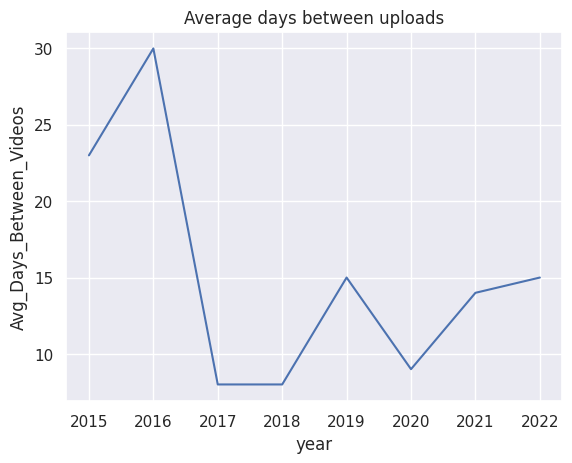

In [ ]:
ax =sns.lineplot(data=result , x="year", y="Avg_Days_Between_Videos").set(title='Average days between uploads')

* Average days between the uploads were highest in 2016
* It was the least in 2017 and 2018 with just 8 days between uploads

## **3.18. Videos with multiple parts and average days between part uploads**





In [ ]:
query = """with title_cleaned as (select 
                substr(Title, 0, instr(lower(REPLACE(title,'Pt.','Part')), 'part')) [Series Name] ,
                 *   
                from video_data
                where (lower(title) like '% part %')  or (lower(title) like '% pt.%') ),
                start_date as ( 
                    select title , 
                    [Series Name], 
                    publishedAt, 
                    LAG ( publishedAt,1,0) OVER ( PARTITION BY [Series Name]	ORDER BY publishedAt )  as start , *
                    from title_cleaned )
               select [Series Name], 
                      count(title) Parts,
                      round(avg(case when start  != 0 then  round(JULIANDAY(publishedAt) - JULIANDAY(start) ,0) else "" end),1) as avg_days 
                      from start_date 
                      group by [Series Name]
                      having count(title)  > 1
                      order by [Series Name]
              """
result = pd.read_sql_query(query,conn)
result 

,Series Name,Parts,avg_days
0,Backpropagation Details,2,0.0
1,Gradient Boost,4,7.0
2,Neural Networks,8,23.6
3,Regularization,3,4.7
4,StatQuest: Random Forests,2,354.5
5,Support Vector Machines,3,11.7
6,XGBoost,4,19.3


* Average days between upload is highest for 	StatQuest: Random Forests Series, but it's close to 1 year.



In [ ]:
query = """select 
                title,
                description,publishedAt
                from video_data
                where title like 'StatQuest: Random Forests Part%'
              """
q211 = pd.read_sql_query(query,conn)
q211 

,title,description,publishedAt
0,StatQuest: Random Forests Part 2: Missing data and clustering,"NOTE: This StatQuest is the updated version of the original Random Forests Part 2 and includes two minor corrections.\n\nLast time we talked about how to create, use and evaluate random forests. Now it's time to see how they can deal with missing data and how they can be used to cluster samples, even when the data comes from all kinds of crazy sources.\n\nNOTE: This StatQuest is based on Leo Breiman's (one of the creators of Random Forests) website: https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm\n\nFor a complete index of all the StatQuest videos, check out:\nhttps://statquest.org/video-index/\n\nIf you'd like to support StatQuest, please consider...\n\nBuying The StatQuest Illustrated Guide to Machine Learning!!!\nPDF - https://statquest.gumroad.com/l/wvtmc\nPaperback - https://www.amazon.com/dp/B09ZCKR4H6\nKindle eBook - https://www.amazon.com/dp/B09ZG79HXC\n\nPatreon: https://www.patreon.com/statquest\n...or...\nYouTube Membership: https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw/join\n\n...a cool StatQuest t-shirt or sweatshirt: \nhttps://shop.spreadshirt.com/statquest-with-josh-starmer/\n\n...buying one or two of my songs (or go large and get a whole album!)\nhttps://joshuastarmer.bandcamp.com/\n\n...or just donating to StatQuest!\nhttps://www.paypal.me/statquest\n\nLastly, if you want to keep up with me as I research and create new StatQuests, follow me on twitter:\nhttps://twitter.com/joshuastarmer\n\n#statquest #randomforest",2020-01-15 17:27:49
1,"StatQuest: Random Forests Part 1 - Building, Using and Evaluating","Random Forests make a simple, yet effective, machine learning method. They are made out of decision trees, but don't have the same problems with accuracy. In this video, I walk you through the steps to build, use and evaluate a random forest.\n\nNOTE: Random Forests are made from Decision Trees, so if you don't know about those, here's the Quest: https://youtu.be/_L39rN6gz7Y\n\nALSO NOTE: This StatQuest is based on Leo Breiman's (one of the creators of Random Forests) website: https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm\n\nFor a complete index of all the StatQuest videos, check out:\nhttps://statquest.org/video-index/\n\nIf you'd like to support StatQuest, please consider...\n\nBuy The StatQuest Illustrated Guide to Machine Learning!!!\nPDF - https://statquest.gumroad.com/l/wvtmc\nPaperback - https://www.amazon.com/dp/B09ZCKR4H6\nKindle eBook - https://www.amazon.com/dp/B09ZG79HXC\n\nPatreon: https://www.patreon.com/statquest\n...or...\nYouTube Membership: https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw/join\n\n...a cool StatQuest t-shirt or sweatshirt: \nhttps://shop.spreadshirt.com/statquest-with-josh-starmer/\n\n...buying one or two of my songs (or go large and get a whole album!)\nhttps://joshuastarmer.bandcamp.com/\n\n...or just donating to StatQuest!\nhttps://www.paypal.me/statquest\n\nLastly, if you want to keep up with me as I research and create new StatQuests, follow me on twitter:\nhttps://twitter.com/joshuastarmer\n\n0:00 Awesome song and introduction\n0:31 Motivation for using Random Forests\n1:17 Step 1, create a bootstrapped dataset\n2:23 Step 2, create a decision tree a random subset of variables at each step\n4:00 Step 3, repeat steps 1 and 2 a bunch of times\n4:40 Classifying a new sample with a Random Forest\n5:41 Definition of Bagging\n6:03 Evaluating a Random Forest\n8:34 Optimizing the Random Forest\n\nCorrections:\n3:18 I should have said the same feature (or variable) can be selected multiple times in a tree. Every time we select a subset of features to choose from, we choose from the full list of features, even if we have already used some of those features. Thus, a single feature can appear multiple times in a tree. \n9:28 I say ""square"" when I meant to say ""square root"".\n\n#statquest #randomforest #ML",2018-02-05 15:55:40


* As we can see it says in description that Part is updated version of the original. We have no way of telling when the original was uploaded, .because the field clearly gets overwritten

# **4. Conclusion**

**Summary**

From the Analysis we were able to come up with the below findings

* Identify best and least performing videos in terms of views
*   Understand that Live videos from this channel tend to be longer than non-live videos
*  Majority of the channel have duration under 15 mins
*  Best and least performing videos in different duration bin
* Yearly stats of the channel. 
 - Seems to suggest that channel had more videos , views , comments and likes in 2018, 2019
 - Interestingly likes and comments per 1000 views is highest  in year 2022 , suggesting higher engagement on videos.
* Since 2019 yoy views has been showing decreasing trend
* Channel has highest views in mid months of July , August and September in most years
*  Average views are highest for videos published on Thursday, Weekend videos have significantly lesser average views
* Average days between the uploads were lowest in years 2017 and 2018
* There are 7 multipart series in the channel and average days between the part upload was identified. We found an outlier here, with further investigation we were able to find out the reason for this anomaly.






**Future Scope**

This is certainly not an extensive EDA on youtube channel analysis

* Here I have only considered one of my Favorite channels for this analysis purpose, this can be extended to multiple channels to compare the different channels
* I have solely concentrated on descriptive analysis using SQL for this project, this can be extended to perform in-depth statistical analysis to identify relationship between different features